In [76]:
import nba_api
import requests

import pandas as pd
import matplotlib.pyplot as plt

import time

In [26]:
#this api has the data I need but it's game-by-game data, not season data.
# https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/boxscoremiscv3.md

#from nba_api.stats.endpoints import boxscoremiscv3
#bs = boxscoremiscv3.BoxScoreMiscV3()

In [4]:
from nba_api.stats.endpoints import teamestimatedmetrics

team estimated metrics is some good stuff, but doesn't include advanced defensive statistics

In [5]:
tem = teamestimatedmetrics.TeamEstimatedMetrics()

In [15]:
tem_df = tem.get_data_frames()[0]

In [19]:
tem_df.loc[tem_df.TEAM_NAME == "Oklahoma City Thunder"]

,TEAM_NAME,TEAM_ID,GP,W,L,W_PCT,MIN,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,E_AST_RATIO,E_OREB_PCT,E_DREB_PCT,E_REB_PCT,E_TM_TOV_PCT,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,E_OFF_RATING_RANK,E_DEF_RATING_RANK,E_NET_RATING_RANK,E_AST_RATIO_RANK,E_OREB_PCT_RANK,E_DREB_PCT_RANK,E_REB_PCT_RANK,E_TM_TOV_PCT_RANK,E_PACE_RANK
4,Oklahoma City Thunder,1610612760,13,12,1,0.923,644.0,116.7,101.9,14.8,101.7,18.1,0.228,0.78,0.515,0.117,1,1,1,1,1,5,1,1,21,25,2,10,2,23


In [24]:

## this API doesn't work anymore, apparently
# from nba_api.stats.endpoints import defensehub

# dh = defensehub.DefenseHub(season="2024-25")

so now we have to play everybody's favorite screen scraping game, reverse engineering some AJAX requests to get what we want.

this is the page I'm trying to scrape data out of: https://www.nba.com/stats/teams/defense?Season=2024-25&dir=A&sort=DEF_RATING

this is the request for the data I want

```
curl.exe ^"https://stats.nba.com/stats/leaguedashteamstats?Conference=^&DateFrom=^&DateTo=^&Division=^&GameScope=^&GameSegment=^&Height=^&ISTRound=^&LastNGames=0^&LeagueID=00^&Location=^&MeasureType=Defense^&Month=0^&OpponentTeamID=0^&Outcome=^&PORound=0^&PaceAdjust=N^&PerMode=PerGame^&Period=0^&PlayerExperience=^&PlayerPosition=^&PlusMinus=N^&Rank=N^&Season=2024-25^&SeasonSegment=^&SeasonType=Regular^%^20Season^&ShotClockRange=^&StarterBench=^&TeamID=0^&TwoWay=0^&VsConference=^&VsDivision=^" ^
  --compressed ^
  -H ^"User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:145.0) Gecko/20100101 Firefox/145.0^" ^
  -H ^"Accept: */*^" ^
  -H ^"Accept-Language: en-US,en;q=0.5^" ^
  -H ^"Accept-Encoding: gzip, deflate, br, zstd^" ^
  -H ^"Referer: https://www.nba.com/^" ^
  -H ^"Origin: https://www.nba.com^" ^
  -H ^"Sec-GPC: 1^" ^
  -H ^"Connection: keep-alive^" ^
  -H ^"Sec-Fetch-Dest: empty^" ^
  -H ^"Sec-Fetch-Mode: cors^" ^
  -H ^"Sec-Fetch-Site: same-site^" ^
  -H ^"Priority: u=4^"
  ```

FIXME: switch this url to per 100 possessions, so I can compare cross-era better

In [67]:
def url_for_season(season="2025-26"):

    url_template = "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=" + \
    "&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Defense&Month=0" + \
    "&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&" + \
    "PlayerPosition=&PlusMinus=N&Rank=N&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season" + \
    "&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision="

    the_url = url_template % {'season' : season}
    return the_url

had to add some headers to keep the request getting blocked:

In [73]:
headers = {
    'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:145.0) Gecko/20100101 Firefox/145.0",
    'Referer' : "https://www.nba.com",
    'Origin'  : "https://www.nba.com",
    "Sec-GPC" : "1", # I think this was the secret sauce, or maybe user-agent
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-site"
}


def nba_scrape_request(season="2025-26"):
    the_url = url_for_season(season)
    r = requests.get(the_url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    return df

In [74]:
def_df = nba_scrape_request()

In [75]:
def_df[def_df.TEAM_NAME=="Oklahoma City Thunder"]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,MIN_RANK,DEF_RATING_RANK,DREB_RANK,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK
20,1610612760,Oklahoma City Thunder,13,12,1,0.923,49.5,103.0,37.0,0.722,...,1,1,1,5,1,13,2,1,2,1


In [63]:
def_df.iloc[20]

TEAM_ID                               1610612760
TEAM_NAME                  Oklahoma City Thunder
GP                                            13
W                                             12
L                                              1
W_PCT                                      0.923
MIN                                         49.5
DEF_RATING                                 103.0
DREB                                        37.0
DREB_PCT                                   0.722
STL                                         10.8
BLK                                          5.2
OPP_PTS_OFF_TOV                             15.4
OPP_PTS_2ND_CHANCE                          11.9
OPP_PTS_FB                                  10.9
OPP_PTS_PAINT                               36.8
GP_RANK                                        2
W_RANK                                         1
L_RANK                                         1
W_PCT_RANK                                     1
MIN_RANK            

In [ ]:
def fetch_seasons(start_year=15, end_year=26):
    years = [x for x in range(start_year, end_year)]

    #year_params = ["20%d-%d" % (x, x+1) for x in range(start_year, end_year)]
    dataframes = []
    for year in years:
        year_param = "20%d-%d" % (year, year+1)
        df = nba_scrape_request(year_param)
        df['SEASON'] = year
        dataframes.append(df)
        print(f"did {year_param}")
        time.sleep(2)

    df = pd.concat(dataframes, ignore_index=True)
    return df

In [122]:
last10 = fetch_seasons(15,26)


did 2015-16
did 2016-17
did 2017-18
did 2018-19
did 2019-20
did 2020-21
did 2021-22
did 2022-23
did 2023-24
did 2024-25
did 2025-26


In [ ]:
last10

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,DEF_RATING_RANK,DREB_RANK,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON
0,1610612737,Atlanta Hawks,82,48,34,0.585,48.4,100.8,33.8,0.698,...,2,13,26,3,5,14,18,9,8,2015-16
1,1610612738,Boston Celtics,82,48,34,0.585,48.2,102.5,33.3,0.707,...,4,15,24,2,22,6,26,3,14,2015-16
2,1610612751,Brooklyn Nets,82,21,61,0.256,48.2,109.7,31.9,0.716,...,29,25,19,19,25,26,11,24,30,2015-16
3,1610612766,Charlotte Hornets,82,48,34,0.585,48.4,103.7,35.0,0.754,...,9,4,1,22,12,2,5,13,3,2015-16
4,1610612741,Chicago Bulls,82,42,40,0.512,48.5,105.5,35.2,0.714,...,15,3,20,29,8,16,27,21,23,2015-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,1610612758,Sacramento Kings,13,3,10,0.231,48.0,120.5,30.4,0.692,...,27,26,15,17,28,18,18,19,27,2025-26
26,1610612759,San Antonio Spurs,12,8,4,0.667,48.4,111.5,34.2,0.713,...,6,6,6,13,6,20,8,1,2,2025-26
27,1610612761,Toronto Raptors,12,7,5,0.583,48.0,114.4,31.9,0.677,...,16,18,18,22,20,5,20,4,19,2025-26
28,1610612762,Utah Jazz,12,4,8,0.333,48.4,118.3,33.3,0.700,...,24,11,11,26,25,25,17,14,10,2025-26


In [ ]:
last10.iloc[0]

TEAM_ID                       1610612737
TEAM_NAME                  Atlanta Hawks
GP                                    82
W                                     48
L                                     34
W_PCT                              0.585
MIN                                 48.4
DEF_RATING                         100.8
DREB                                33.8
DREB_PCT                           0.698
STL                                  9.1
BLK                                  5.9
OPP_PTS_OFF_TOV                     16.0
OPP_PTS_2ND_CHANCE                  13.1
OPP_PTS_FB                          11.9
OPP_PTS_PAINT                       40.9
GP_RANK                                1
W_RANK                                 7
L_RANK                                 7
W_PCT_RANK                             7
MIN_RANK                              11
DEF_RATING_RANK                        2
DREB_RANK                             13
DREB_PCT_RANK                         26
STL_RANK        

In [ ]:
last10.OPP_PTS_PAINT.describe()

count    330.000000
mean      47.483030
std        3.959209
min       36.800000
25%       44.800000
50%       47.500000
75%       50.175000
max       58.400000
Name: OPP_PTS_PAINT, dtype: float64

how has defensive rating changed over the past 10 years?

In [ ]:
last10.groupby('SEASON')['DEF_RATING'].mean()

SEASON
2015-16    105.536667
2016-17    108.143333
2017-18    107.840000
2018-19    109.730000
2019-20    110.153333
2020-21    111.696667
2021-22    111.360000
2022-23    114.070000
2023-24    114.516667
2024-25    113.683333
2025-26    114.863333
Name: DEF_RATING, dtype: float64

I'd like to visualize all these teams in an easy to understand way... I'm going to use 2D PCA.

It's kind of a cliche to have the scatterplot with one crazy outlier. but the classics are the classics because people like them

In [85]:
from sklearn.decomposition import PCA

In [138]:
last10.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'DEF_RATING',
       'DREB', 'DREB_PCT', 'STL', 'BLK', 'OPP_PTS_OFF_TOV',
       'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK',
       'DREB_RANK', 'DREB_PCT_RANK', 'STL_RANK', 'BLK_RANK',
       'OPP_PTS_OFF_TOV_RANK', 'OPP_PTS_2ND_CHANCE_RANK', 'OPP_PTS_FB_RANK',
       'OPP_PTS_PAINT_RANK', 'SEASON', 'PCA_1', 'PCA_2'],
      dtype='object')

In [147]:
cols_for_training = ['DEF_RATING', 'DREB', 'DREB_PCT', 'STL', 'BLK', 'OPP_PTS_OFF_TOV',
                    'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT']

rank_cols = [ 'DREB_PCT_RANK','STL_RANK', 'BLK_RANK',
       'OPP_PTS_OFF_TOV_RANK', 'OPP_PTS_2ND_CHANCE_RANK', 'OPP_PTS_FB_RANK',
       'OPP_PTS_PAINT_RANK'] # omitting 'DEF_RATING_RANK' because it is redundant (in theory, with PCA)

last10[rank_cols]

,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK
0,26,3,5,14,18,9,8
1,24,2,22,6,26,3,14
2,19,19,25,26,11,24,30
3,1,22,12,2,5,13,3
4,20,29,8,16,27,21,23
...,...,...,...,...,...,...,...
25,15,17,28,18,18,19,27
26,6,13,6,20,8,1,2
27,18,22,20,5,20,4,19
28,11,26,25,25,17,14,10


In [148]:
model = PCA(n_components=2, whiten=True)

train_data = last10[rank_cols] # rank might be fairer

X_reduced = model.fit_transform(train_data)

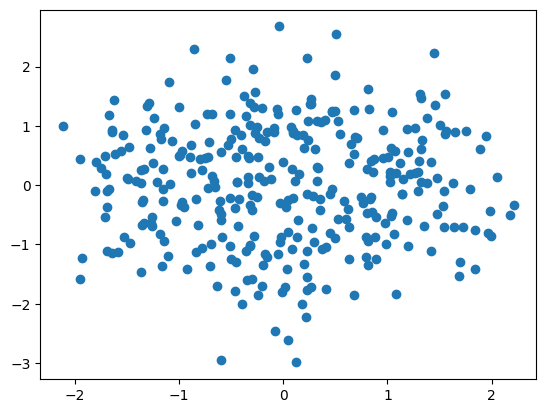

In [149]:
plt.scatter(X_reduced[:,0],X_reduced[:,1])

In [150]:
last10['PCA_1'] = X_reduced[:,0]
last10['PCA_2'] = X_reduced[:,1]

In [151]:
this_season = last10.loc[(last10.SEASON==25)].copy()

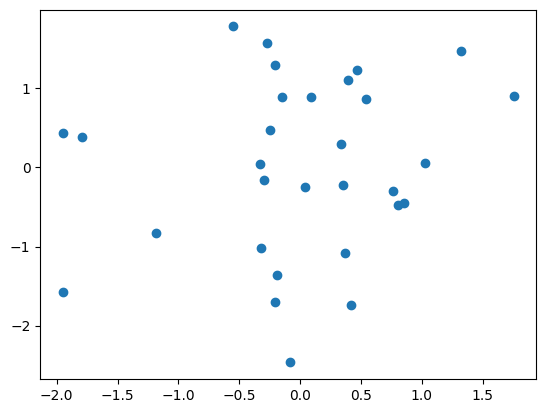

In [152]:
plt.scatter(this_season.PCA_1, this_season.PCA_2)

In [153]:
this_season.loc[this_season.TEAM_NAME == "Oklahoma City Thunder"]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON,PCA_1,PCA_2
20,1610612760,Oklahoma City Thunder,13,12,1,0.923,49.5,103.0,37.0,0.722,...,5,1,13,2,1,2,1,25,-1.949853,-1.580576


In [154]:
this_season.loc[this_season.PCA_1 < -1]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,DEF_RATING,DREB,DREB_PCT,...,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,SEASON,PCA_1,PCA_2
7,1610612743,Denver Nuggets,11,9,2,0.818,48.5,109.4,35.7,0.723,...,4,20,26,3,2,3,7,25,-1.950721,0.438645
19,1610612752,New York Knicks,12,8,4,0.667,48.0,114.3,32.0,0.735,...,2,18,24,6,3,8,5,25,-1.791488,0.390740
20,1610612760,Oklahoma City Thunder,13,12,1,0.923,49.5,103.0,37.0,0.722,...,5,1,13,2,1,2,1,25,-1.949853,-1.580576
26,1610612759,San Antonio Spurs,12,8,4,0.667,48.4,111.5,34.2,0.713,...,6,13,6,20,8,1,2,25,-1.182696,-0.825275


ok, what about collapsing it all down to one number?

where does OKC's defensive ranking match up with teams over the past 5 seasons?

In [145]:
this_season.iloc[7]

TEAM_ID                        1610612743
TEAM_NAME                  Denver Nuggets
GP                                     11
W                                       9
L                                       2
W_PCT                               0.818
MIN                                  48.5
DEF_RATING                          109.4
DREB                                 35.7
DREB_PCT                            0.723
STL                                   8.1
BLK                                   3.6
OPP_PTS_OFF_TOV                      15.7
OPP_PTS_2ND_CHANCE                   12.6
OPP_PTS_FB                           11.1
OPP_PTS_PAINT                        47.5
GP_RANK                                28
W_RANK                                  3
L_RANK                                  2
W_PCT_RANK                              3
MIN_RANK                                7
DEF_RATING_RANK                         2
DREB_RANK                               3
DREB_PCT_RANK                     

In [155]:
model = PCA(n_components=1, whiten=True)

train_data = last10[rank_cols] # rank might be fairer

X_reduced_1d = model.fit_transform(train_data)

In [169]:
train_data


,DREB_PCT_RANK,STL_RANK,BLK_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK
0,26,3,5,14,18,9,8
1,24,2,22,6,26,3,14
2,19,19,25,26,11,24,30
3,1,22,12,2,5,13,3
4,20,29,8,16,27,21,23
...,...,...,...,...,...,...,...
25,15,17,28,18,18,19,27
26,6,13,6,20,8,1,2
27,18,22,20,5,20,4,19
28,11,26,25,25,17,14,10


In [158]:
pca_1d = pd.Series(X_reduced_1d[:,0])

In [159]:
pca_1d

0      0.177844
1      0.037848
2      0.816794
3     -1.692530
4      0.956527
         ...   
325    0.465427
326   -1.182696
327   -0.332206
328   -0.205378
329    1.756123
Length: 330, dtype: float64

In [160]:
last10['PCA_1D'] = pca_1d

In [161]:
last10.PCA_1D.describe()

count    330.000000
mean       0.001177
std        1.111825
min       -1.692530
25%       -0.886477
50%       -0.049410
75%        1.021272
max        2.173089
Name: PCA_1D, dtype: float64

In [ ]:
last10[last10.OPP_PTS_FB_RANK <= 3]

the thunder have been in the top 3 in 6/10 previous seasons on opponent fast break points

In [173]:
last10[last10.OPP_PTS_FB_RANK <= 3].groupby('TEAM_NAME')['TEAM_NAME'].count()

TEAM_NAME
Boston Celtics           1
Charlotte Hornets        2
Denver Nuggets           1
Detroit Pistons          3
Houston Rockets          1
Indiana Pacers           2
Miami Heat               4
Milwaukee Bucks          3
New York Knicks          2
Oklahoma City Thunder    6
Sacramento Kings         3
San Antonio Spurs        1
Utah Jazz                3
Washington Wizards       1
Name: TEAM_NAME, dtype: int64

In [175]:
last10[last10.OPP_PTS_PAINT_RANK <= 3].groupby('TEAM_NAME')['TEAM_NAME'].count()

TEAM_NAME
Atlanta Hawks             1
Boston Celtics            3
Charlotte Hornets         1
Chicago Bulls             1
Cleveland Cavaliers       1
Dallas Mavericks          1
Golden State Warriors     1
Memphis Grizzlies         4
Miami Heat                5
Milwaukee Bucks           3
Minnesota Timberwolves    1
New York Knicks           2
Oklahoma City Thunder     2
Orlando Magic             1
Philadelphia 76ers        1
Portland Trail Blazers    1
San Antonio Spurs         1
Toronto Raptors           2
Utah Jazz                 2
Name: TEAM_NAME, dtype: int64

what about just summing the ranks up?

In [179]:
last10[rank_cols].T.sum()

0      83
1      97
2     154
3      58
4     144
     ... 
25    142
26     56
27    108
28    128
29    167
Length: 330, dtype: int64